In [1]:
# Set up

%load_ext autoreload
%autoreload 2

import torch
import random
from transformer_lens import HookedTransformer
from transformer_lens.utils import get_device, get_act_name
import numpy as np
import matplotlib.pyplot as plt

from attribution_methods import integrated_gradients, activation_patching, highlight_components
from testing import Task, TaskDataset, logit_diff_metric, identify_outliers, average_correlation, measure_overlap, test_single_ablated_performance, test_multi_ablated_performance
from plotting import plot_attn, plot_attn_comparison, plot_correlation, plot_correlation_comparison, plot_bar_chart

/vol/bitbucket/mwl21/fypvenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ig_mlp = torch.load("results/aligned/ioi/ig_mlp.pt")
ig_attn = torch.load("results/aligned/ioi/ig_attn.pt")

ap_mlp = torch.load("results/aligned/ioi/ap_mlp.pt")
ap_attn = torch.load("results/aligned/ioi/ap_attn.pt")

In [38]:
mlp_outlier_iso = torch.load("results/disagreements/mlp_outlier_isolated_ablation_scores.pt")
attn_outlier_iso = torch.load("results/disagreements/attn_outlier_isolated_ablation_scores.pt")

In [4]:
mlp_outlier_iso_scores = torch.tensor([v for d in mlp_outlier_iso for v in d.values()])
avg_mlp_outlier_iso_score = mlp_outlier_iso_scores.mean()
std_mlp_outlier_iso_score = mlp_outlier_iso_scores.std()
print(f"Average MLP outlier isolated ablation score: {avg_mlp_outlier_iso_score:.4f} ± {std_mlp_outlier_iso_score:.4f}")

Average MLP outlier isolated ablation score: 0.6356 ± 0.1305


In [39]:
attn_outlier_iso_scores = torch.tensor([v for d in attn_outlier_iso for v in d.values()])
avg_attn_outlier_iso_score = attn_outlier_iso_scores.mean()
std_attn_outlier_iso_score = attn_outlier_iso_scores.std()
print(f"Average attn outlier isolated ablation score: {avg_attn_outlier_iso_score:.4f} ± {std_attn_outlier_iso_score:.4f}")

Average attn outlier isolated ablation score: 0.2423 ± 0.3730


### IGNORE

In [ ]:
# Calculate average absolute attribution scores
mlp_outlier_ap_scores = {}

for sample, sample_mlp_outlier_iso in mlp_outlier_iso.items():
    for (layer, idx), score in sample_mlp_outlier_iso.items():
        if (layer, idx) not in mlp_outlier_ap_scores:
            mlp_outlier_ap_scores[(layer, idx)] = torch.zeros_like(ap_mlp[0, layer, idx])
        mlp_outlier_ap_scores[(layer, idx)] += torch.abs(ap_mlp[0, layer, idx])

for (layer, idx) in mlp_outlier_iso.keys():
    mlp_outlier_ap_scores[(layer, idx)] = ap_mlp[0, layer, idx]

n_mlp_outliers = len(mlp_outlier_iso)

# For now, one sample only
xs = torch.ones((1, n_mlp_outliers))
ys = torch.ones((1, n_mlp_outliers))

for i, ((layer, idx), score) in enumerate(mlp_outlier_iso.items()):
    xs[0, i] = mlp_outlier_ap_scores[(layer, idx)]
    ys[0, i] = score.item()

plot_correlation(
    xs,
    ys,
    x_label="Activation patching attribution score",
    y_label="Model performance under isolated ablation",
    title="Activation patching attribution scores versus isolated ablation performance for exclusive neurons",
)

AttributeError: 'list' object has no attribute 'keys'

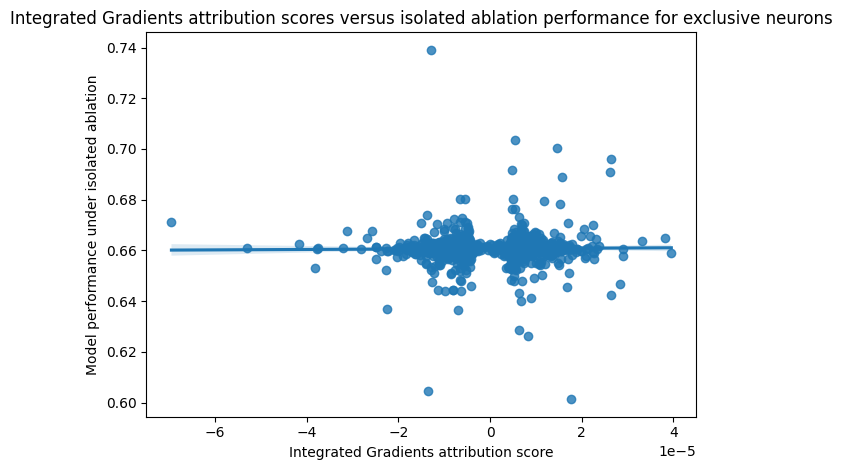

Correlation coefficient: 0.017030091231588242


In [61]:
# Calculate average absolute attribution scores
mlp_outlier_ig_scores = {}

for (layer, idx) in mlp_outlier_iso.keys():
    mlp_outlier_ig_scores[(layer, idx)] = ig_mlp[0, layer, idx]

n_mlp_outliers = len(mlp_outlier_iso)

# For now, one sample only
xs = torch.ones((1, n_mlp_outliers))
ys = torch.ones((1, n_mlp_outliers))

for i, ((layer, idx), score) in enumerate(mlp_outlier_iso.items()):
    xs[0, i] = mlp_outlier_ig_scores[(layer, idx)]
    ys[0, i] = score.item()

plot_correlation(
    xs,
    ys,
    x_label="Integrated Gradients attribution score",
    y_label="Model performance under isolated ablation",
    title="Integrated Gradients attribution scores versus isolated ablation performance for exclusive neurons",
)

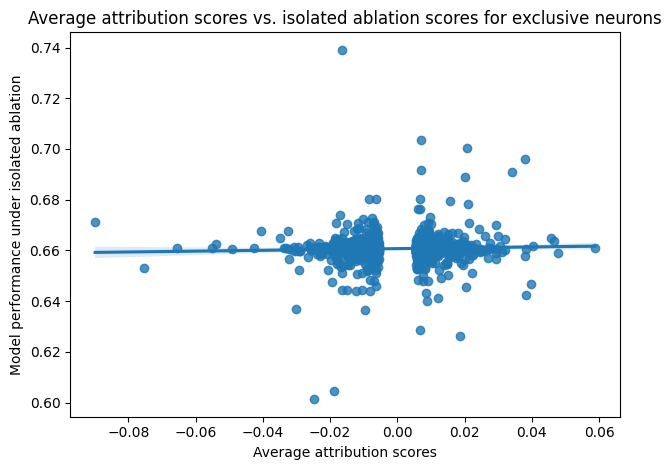

Correlation coefficient: 0.045335963338861106


In [63]:
# Calculate average absolute attribution scores
mlp_average_absolute_scores = {}

for (layer, idx) in mlp_outlier_iso.keys():
    ig_score = ig_mlp[0, layer, idx]
    ap_score = ap_mlp[0, layer, idx]
    avg_absolute_score = (ig_score + ap_score) / 2
    mlp_average_absolute_scores[(layer, idx)] = avg_absolute_score.item()

n_mlp_outliers = len(mlp_outlier_iso)

# For now, one sample only
xs = torch.ones((1, n_mlp_outliers))
ys = torch.ones((1, n_mlp_outliers))

for i, ((layer, idx), score) in enumerate(mlp_outlier_iso.items()):
    xs[0, i] = mlp_average_absolute_scores[(layer, idx)]
    ys[0, i] = score.item()

plot_correlation(
    xs,
    ys,
    x_label="Average attribution scores",
    y_label="Model performance under isolated ablation",
    title="Average attribution scores vs. isolated ablation scores for exclusive neurons",
)

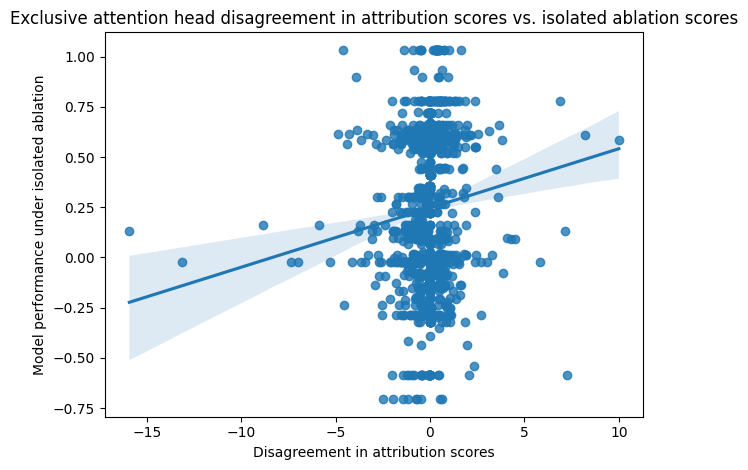

Correlation coefficient: 0.09870634893870354


In [71]:
attn_diff_scores = {}

for s, sample_attn_outlier_iso in enumerate(attn_outlier_iso):
    for layer, idx in sample_attn_outlier_iso.keys():
        ig_score = ig_attn[s, layer, idx]
        ap_score = ap_attn[s, layer, idx]
        diff = ap_score - ig_score
        attn_diff_scores[(s, layer, idx)] = diff.item()

xs = []
ys = []

for (sample, layer, idx), score in attn_diff_scores.items():
    xs.append(score)
    ys.append(attn_outlier_iso[sample][(layer, idx)])

xs = torch.tensor(xs).unsqueeze(0)
ys = torch.tensor(ys).unsqueeze(0)

plot_correlation(
    xs,
    ys,
    x_label="Disagreement in attribution scores",
    y_label="Model performance under isolated ablation",
    title="Exclusive attention head disagreement in attribution scores vs. isolated ablation scores",
)

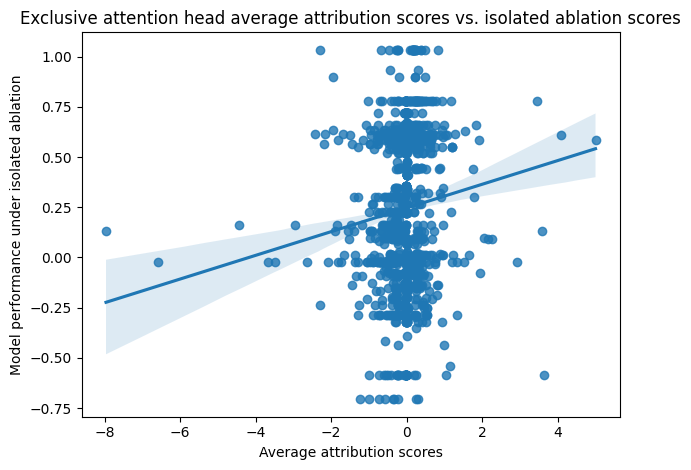

Correlation coefficient: 0.09872015962807701


In [70]:
attn_average_attribution_scores = {}

for s, sample_attn_outlier_iso in enumerate(attn_outlier_iso):
    for layer, idx in sample_attn_outlier_iso.keys():
        ig_score = ig_attn[s, layer, idx]
        ap_score = ap_attn[s, layer, idx]
        average = (ig_score + ap_score) / 2
        attn_average_attribution_scores[(s, layer, idx)] = average.item()

xs = []
ys = []

for (sample, layer, idx), score in attn_average_attribution_scores.items():
    xs.append(score)
    ys.append(attn_outlier_iso[sample][(layer, idx)])

xs = torch.tensor(xs).unsqueeze(0)
ys = torch.tensor(ys).unsqueeze(0)

plot_correlation(
    xs,
    ys,
    x_label="Average attribution scores",
    y_label="Model performance under isolated ablation",
    title="Exclusive attention head average attribution scores vs. isolated ablation scores",
)

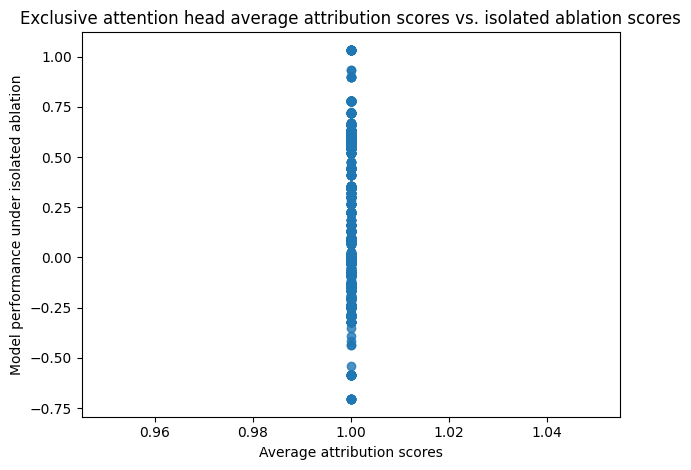

Correlation coefficient: nan


/vol/bitbucket/mwl21/fypvenv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/vol/bitbucket/mwl21/fypvenv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [74]:
# Proportion of times AP is higher than IG for attention heads
attn_average_attribution_scores = {}

for s, sample_attn_outlier_iso in enumerate(attn_outlier_iso):
    for layer, idx in sample_attn_outlier_iso.keys():
        ig_score = ig_attn[s, layer, idx]
        ap_score = ap_attn[s, layer, idx]
        average = int(ap_score.abs() > 0)
        attn_average_attribution_scores[(s, layer, idx)] = average

xs = []
ys = []

for (sample, layer, idx), score in attn_average_attribution_scores.items():
    xs.append(score)
    ys.append(attn_outlier_iso[sample][(layer, idx)])

xs = torch.tensor(xs).unsqueeze(0)
ys = torch.tensor(ys).unsqueeze(0)

plot_correlation(
    xs,
    ys,
    x_label="Average attribution scores",
    y_label="Model performance under isolated ablation",
    title="Exclusive attention head average attribution scores vs. isolated ablation scores",
)


In [80]:
mlp_outlier_ap_scores = []

n_samples = len(mlp_outlier_iso)

for (layer, idx) in mlp_outlier_iso.keys():
    ig_score = ig_mlp[0, layer, idx]
    ap_score = ap_mlp[0, layer, idx]

    mlp_outlier_ap_scores.append(ap_score.item())

# Minimum AP magnitude
min_ap_magnitude = min(abs(score) for score in mlp_outlier_ap_scores)
print(f"Minimum activation patching magnitude: {min_ap_magnitude:.4f}")

Minimum activation patching magnitude: 0.0111


### Visualise distribution of data

In [6]:
# Integrated gradients scores for MLP outliers
mlp_outlier_ig_scores = []
mlp_outlier_ap_scores = []

for s, sample_mlp_outlier_iso in enumerate(mlp_outlier_iso):
    for layer, idx in sample_mlp_outlier_iso.keys():
        ig_score = ig_mlp[s, layer, idx]
        ap_score = ap_mlp[s, layer, idx]
        mlp_outlier_ig_scores.append(ig_score.item())
        mlp_outlier_ap_scores.append(ap_score.item())

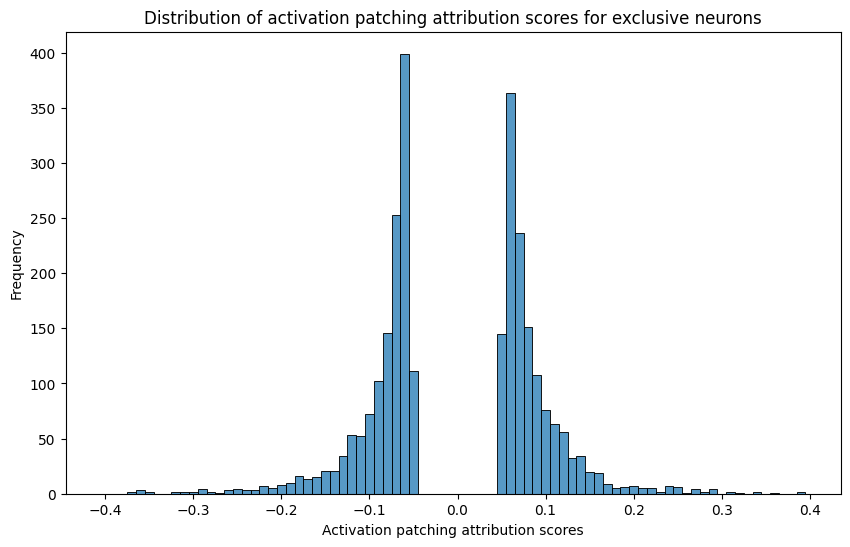

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

bin_width = 0.01
bins = np.arange(-0.4, 0.4 + bin_width, bin_width)
# Shift bins by half bin width to center them
bins = bins - bin_width / 2

plt.figure(figsize=(10, 6))
sns.histplot(mlp_outlier_ap_scores, bins=bins, kde=False)
plt.title("Distribution of activation patching attribution scores for exclusive neurons")
plt.xlabel("Activation patching attribution scores")
plt.ylabel("Frequency")
plt.show()

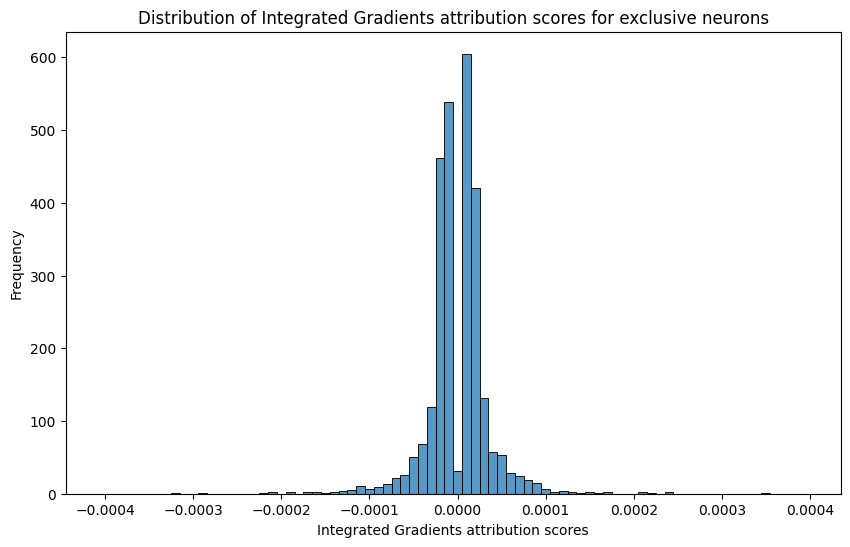

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

bin_width = 1e-5
bins = np.arange(-4e-4, 4e-4 + bin_width, bin_width)
# Shift bins by half bin width to center them
bins = bins - bin_width / 2

plt.figure(figsize=(10, 6))
sns.histplot(mlp_outlier_ig_scores, bins=bins, kde=False)
plt.title("Distribution of Integrated Gradients attribution scores for exclusive neurons")
plt.xlabel("Integrated Gradients attribution scores")
plt.ylabel("Frequency")
plt.show()

In [40]:
# Integrated gradients scores for attention outliers
attn_outlier_ig_scores = []
attn_outlier_ap_scores = []

for s, sample_attn_outlier_iso in enumerate(attn_outlier_iso):
    for layer, idx in sample_attn_outlier_iso.keys():
        ig_score = ig_attn[s, layer, idx]
        ap_score = ap_attn[s, layer, idx]
        attn_outlier_ig_scores.append(ig_score.item())
        attn_outlier_ap_scores.append(ap_score.item())

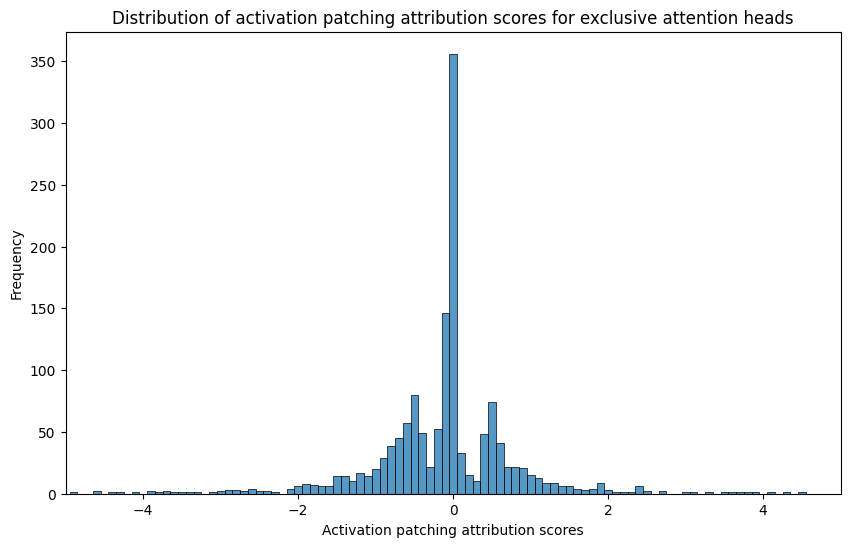

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

bin_width = 0.1
bins = np.arange(-5, 5 + bin_width, bin_width)
# Shift bins by half bin width to center them
bins = bins - bin_width / 2

plt.figure(figsize=(10, 6))
sns.histplot(attn_outlier_ap_scores, bins=bins, kde=False)
plt.title("Distribution of activation patching attribution scores for exclusive attention heads")
plt.xlabel("Activation patching attribution scores")
plt.ylabel("Frequency")
plt.xlim(-5, 5)
plt.show()

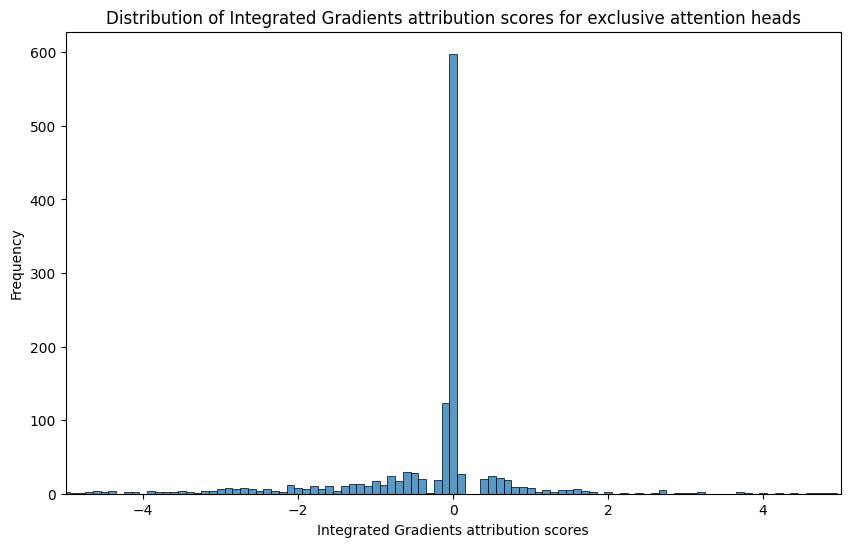

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

bin_width = 0.1
bins = np.arange(-5, 5 + bin_width, bin_width)
# Shift bins by half bin width to center them
bins = bins - bin_width / 2

scaled_attn_outlier_ig_scores = [score * 1e5 for score in attn_outlier_ig_scores]  # Scale for better visualization

plt.figure(figsize=(10, 6))
sns.histplot(scaled_attn_outlier_ig_scores, bins=bins, kde=False)
plt.title("Distribution of Integrated Gradients attribution scores for exclusive attention heads")
plt.xlabel("Integrated Gradients attribution scores")
plt.ylabel("Frequency")
plt.xlim(-5, 5)
plt.show()

### Plot each distribution

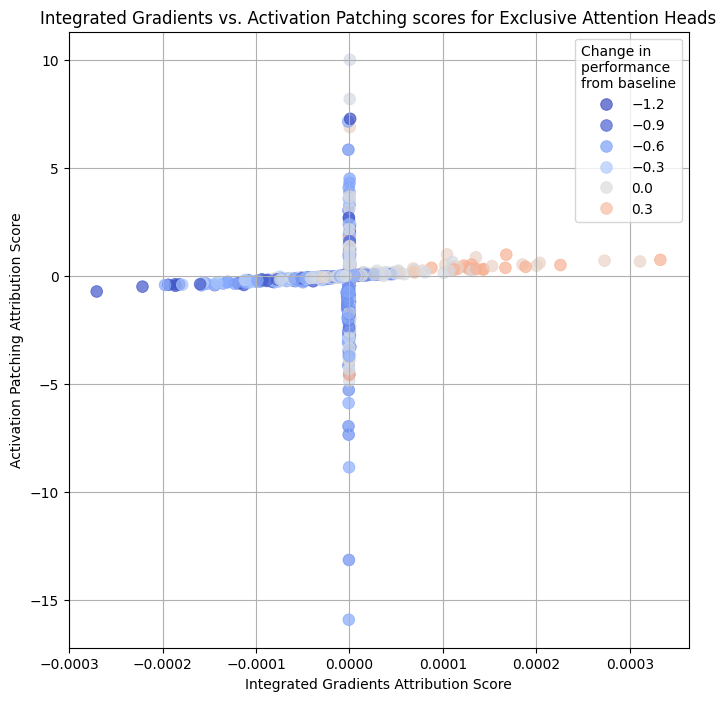

In [19]:
from matplotlib.colors import TwoSlopeNorm

# Plot IG vs AP score for attention head outliers
xs = []
ys = []
impact = []

for s, sample_attn_outlier_iso in enumerate(attn_outlier_iso):
    for layer, idx in sample_attn_outlier_iso.keys():
        ig_score = ig_attn[s, layer, idx]
        ap_score = ap_attn[s, layer, idx]

        xs.append(ig_score.item())
        ys.append(ap_score.item())
        change_in_performance = attn_outlier_iso[s][(layer, idx)] - 0.661 # baseline performance
        impact.append(change_in_performance)

plt.figure(figsize=(8, 8))

norm = TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)
sns.scatterplot(x=xs, y=ys, hue=impact, palette="coolwarm", hue_norm=norm, s=70, edgecolor=None, alpha=0.7)

plt.title("Integrated Gradients vs. Activation Patching scores for Exclusive Attention Heads")
plt.xlabel("Integrated Gradients Attribution Score")
plt.ylabel("Activation Patching Attribution Score")
plt.grid(True)
# plt.ylim(-30, 30)
# plt.xlim(-30, 30)
plt.legend(title="Change in \nperformance \nfrom baseline")
plt.show()

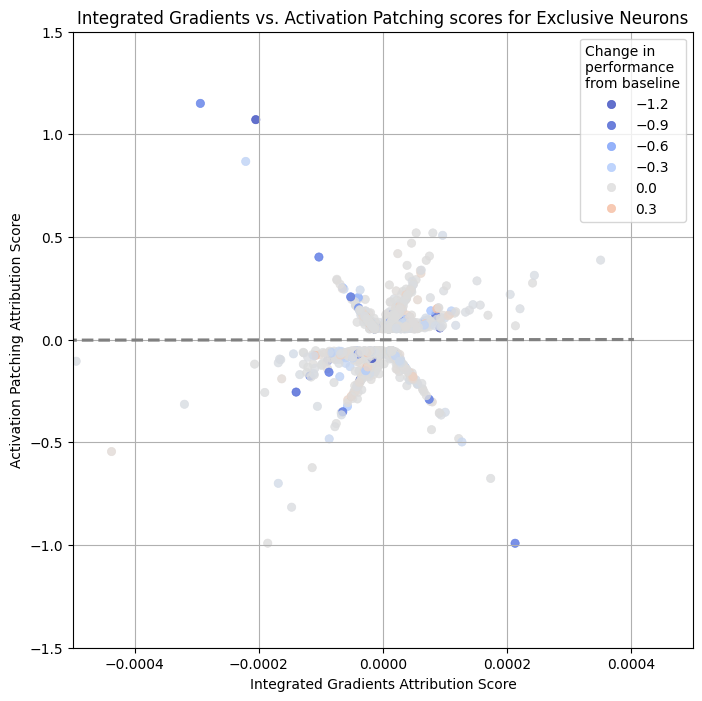

In [9]:
from matplotlib.colors import TwoSlopeNorm
import seaborn as sns
import matplotlib.pyplot as plt

# Plot IG vs AP score for neuron outliers
xs = []
ys = []
impact = []

for s, sample_mlp_outlier_iso in enumerate(mlp_outlier_iso):
    for layer, idx in sample_mlp_outlier_iso.keys():
        ig_score = ig_mlp[s, layer, idx]
        ap_score = ap_mlp[s, layer, idx]

        xs.append(ig_score.item())
        ys.append(ap_score.item())
        change_in_performance = sample_mlp_outlier_iso[(layer, idx)] - 0.661 # baseline performance
        impact.append(change_in_performance)

plt.figure(figsize=(8, 8))

norm = TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)

sns.regplot(x=xs, y=ys, scatter=False, ci=None, color='gray', line_kws={'linestyle': '--'})
sns.scatterplot(x=xs, y=ys, hue=impact, palette="coolwarm", hue_norm=norm, edgecolor=None, alpha=0.8)

plt.title("Integrated Gradients vs. Activation Patching scores for Exclusive Neurons")
plt.xlabel("Integrated Gradients Attribution Score")
plt.ylabel("Activation Patching Attribution Score")
plt.grid(True)
plt.ylim(-1.5, 1.5)
plt.xlim(-5e-4, 5e-4)
plt.legend(title="Change in \nperformance \nfrom baseline")
plt.show()

### Plot overlapping distributions

In [254]:
max(mlp_outlier_ap_scores)

0.00035112129990011454

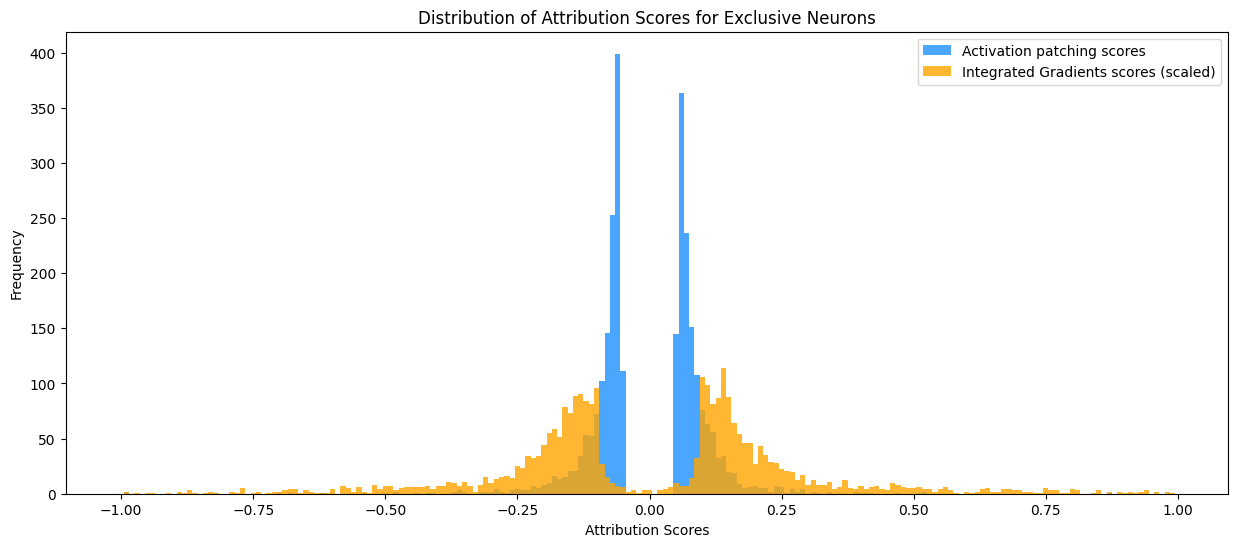

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

bin_width = 0.01
bins = np.arange(-1, 1 + bin_width, bin_width)
# Shift bins by half bin width to center them
bins = bins - bin_width / 2

scaled_mlp_outlier_ig_scores = [score * 1e4 for score in mlp_outlier_ig_scores]

plt.figure(figsize=(15, 6))
sns.histplot(mlp_outlier_ap_scores, bins=bins, color='dodgerblue', edgecolor='none', alpha=0.8, label='Activation patching scores')
sns.histplot(scaled_mlp_outlier_ig_scores, bins=bins, color='orange', edgecolor='none', alpha=0.8, label='Integrated Gradients scores (scaled)')
plt.title("Distribution of Attribution Scores for Exclusive Neurons")
plt.xlabel("Attribution Scores")
plt.ylabel("Frequency")
plt.legend()
plt.show()

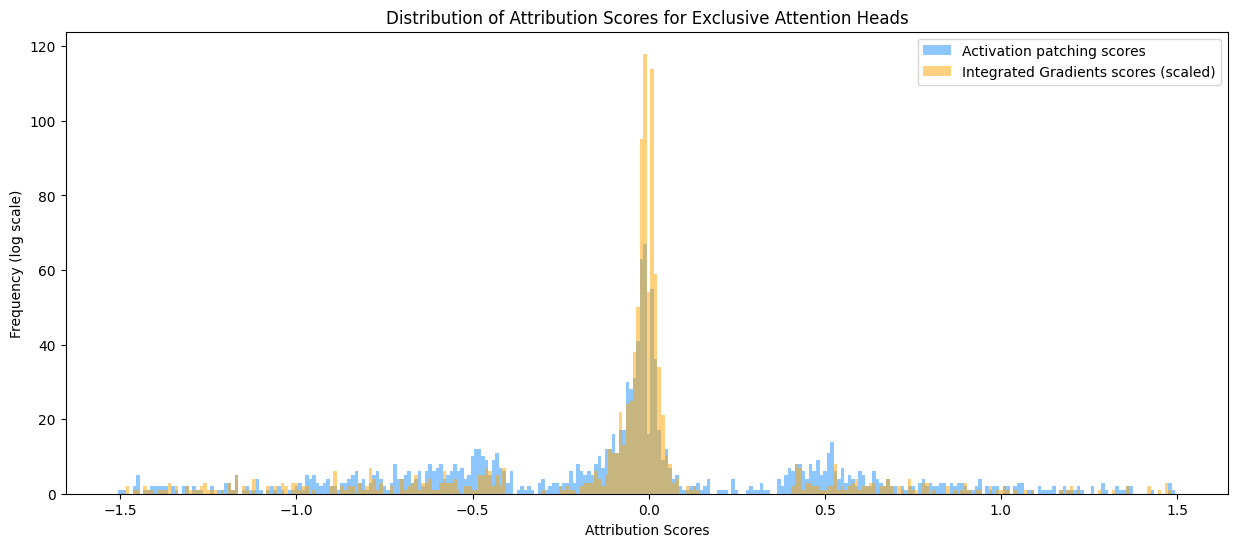

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

bin_width = 0.01
bins = np.arange(-1.5, 1.5 + bin_width, bin_width)
# Shift bins by half bin width to center them
bins = bins - bin_width / 2

plt.figure(figsize=(15, 6))
sns.histplot(attn_outlier_ap_scores, bins=bins, color='dodgerblue', edgecolor='none', alpha=0.5, label='Activation patching scores')
sns.histplot(scaled_attn_outlier_ig_scores, bins=bins, color='orange', edgecolor='none', alpha=0.5, label='Integrated Gradients scores (scaled)')
plt.title("Distribution of Attribution Scores for Exclusive Attention Heads")
plt.xlabel("Attribution Scores")
plt.ylabel("Frequency (log scale)")
# plt.yscale('log')
plt.legend()
plt.show()

## Compare latents and subset of disagreements

Hypothesis: Latent components are those which have disagreements, where IG > AP.

In [9]:
ig_corrupt_clean_mlp = torch.load("results/latent_components/ioi/ig_corrupt_clean_mlp.pt")
ap_corrupt_clean_mlp = torch.load("results/latent_components/ioi/ap_corrupt_clean_mlp.pt")

ig_corrupt_clean_attn = torch.load("results/latent_components/ioi/ig_corrupt_clean_attn.pt")
ap_corrupt_clean_attn = torch.load("results/latent_components/ioi/ap_corrupt_clean_attn.pt")

ig_clean_corrupt_mlp = torch.load("results/latent_components/ioi/ig_clean_corrupt_mlp.pt")
ap_clean_corrupt_mlp = torch.load("results/latent_components/ioi/ap_clean_corrupt_mlp.pt")

ig_clean_corrupt_attn = torch.load("results/latent_components/ioi/ig_clean_corrupt_attn.pt")
ap_clean_corrupt_attn = torch.load("results/latent_components/ioi/ap_clean_corrupt_attn.pt")

In [10]:
# Identify latent compoenents
from attribution_methods import highlight_components, asymmetry_score

ap_mlp_asymmetry = asymmetry_score(ap_corrupt_clean_mlp, ap_clean_corrupt_mlp, is_ig=False)
ap_attn_asymmetry = asymmetry_score(ap_corrupt_clean_attn, ap_clean_corrupt_attn, is_ig=False)

true_latent_mlp, true_latent_mlp_indices = highlight_components(ap_mlp_asymmetry)
true_latent_attn, true_latent_attn_indices = highlight_components(ap_attn_asymmetry)

In [11]:
# Measure disagreement between IG and AP

# AND
and_attn = ig_corrupt_clean_attn * 1e4 - ap_corrupt_clean_attn
and_mlp = ig_corrupt_clean_mlp * 1e4 - ap_corrupt_clean_mlp

# OR
or_attn  = ap_clean_corrupt_attn - ig_clean_corrupt_attn * 1e4
or_mlp = ap_clean_corrupt_mlp - ig_clean_corrupt_mlp * 1e4

In [12]:
# Correlation between asymmetry (latents) and disagreements (IG > AP)
from testing import average_correlation

mlp_and_corr, mlp_and_corr_std = average_correlation(ap_mlp_asymmetry, and_mlp)
print(f"MLP AND correlation: {mlp_and_corr:.4f} ± {mlp_and_corr_std:.4f}")

attn_and_corr, attn_and_corr_std = average_correlation(ap_attn_asymmetry, and_attn)
print(f"Attention AND correlation: {attn_and_corr:.4f} ± {attn_and_corr_std:.4f}")

mlp_or_corr, mlp_or_corr_std = average_correlation(ap_mlp_asymmetry, or_mlp)
print(f"MLP OR correlation: {mlp_or_corr:.4f} ± {mlp_or_corr_std:.4f}")

attn_or_corr, attn_or_corr_std = average_correlation(ap_attn_asymmetry, or_attn)
print(f"Attention OR correlation: {attn_or_corr:.4f} ± {attn_or_corr_std:.4f}")

MLP AND correlation: -0.3270 ± 0.2385
Attention AND correlation: -0.1421 ± 0.2742
MLP OR correlation: 0.2790 ± 0.2946
Attention OR correlation: -0.1245 ± 0.2829


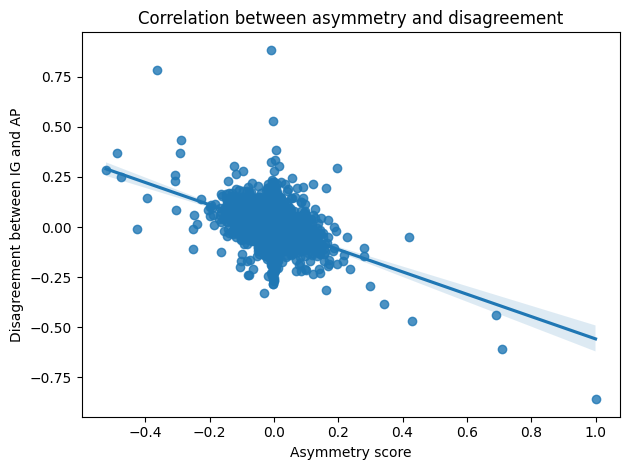

Correlation coefficient: -0.3861630456856009


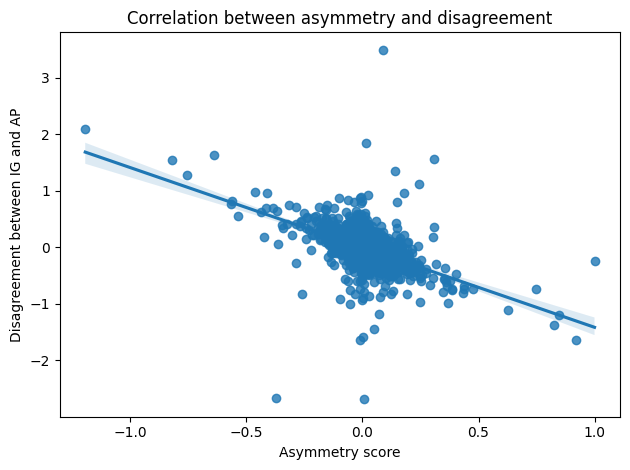

Correlation coefficient: -0.47636714184867385


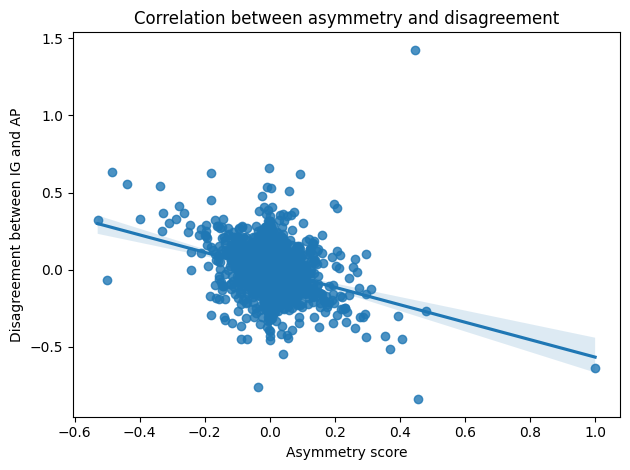

Correlation coefficient: -0.2799271490800171


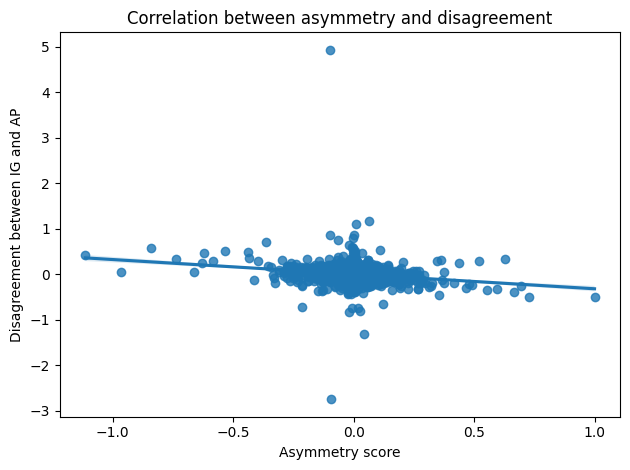

Correlation coefficient: -0.1953209107944753


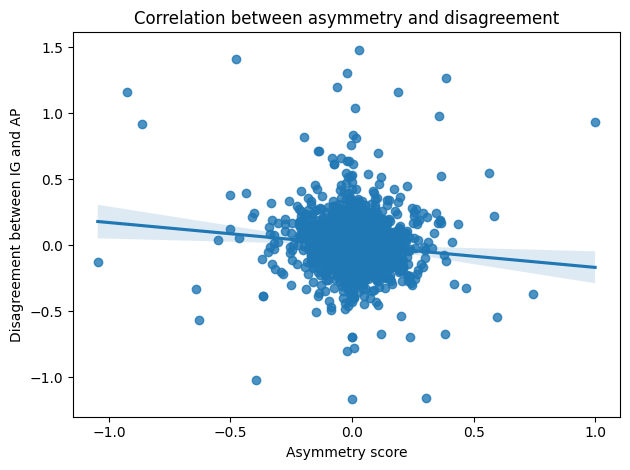

Correlation coefficient: -0.09463804449074391


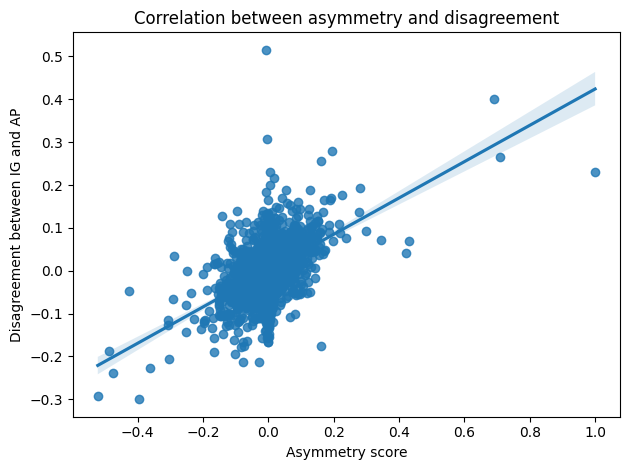

Correlation coefficient: 0.46407569756111977


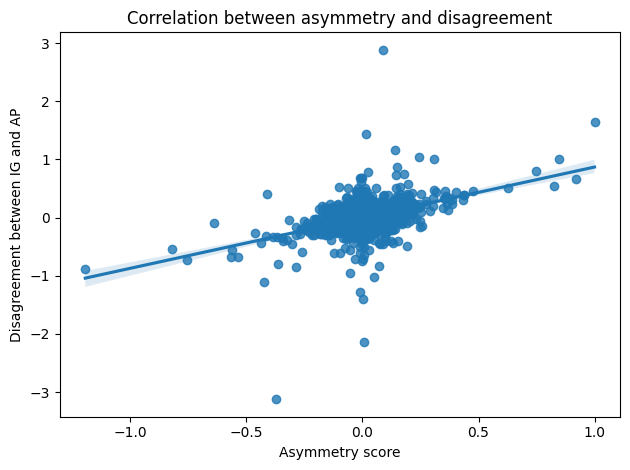

Correlation coefficient: 0.3962290017861696


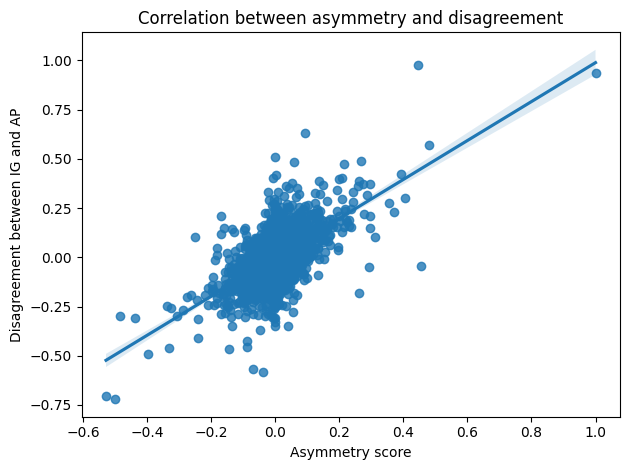

Correlation coefficient: 0.5550844434479547


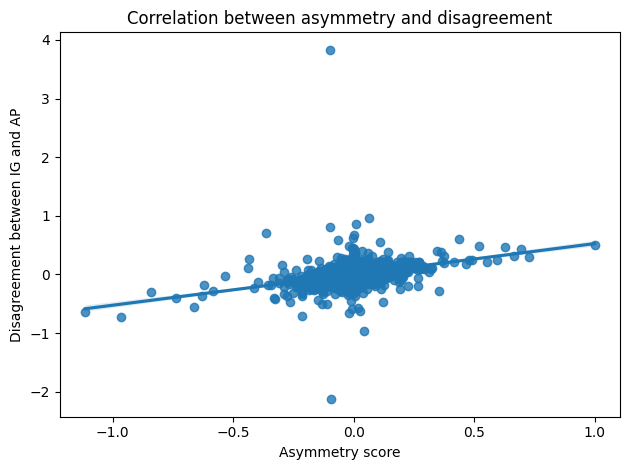

Correlation coefficient: 0.37016117799922976


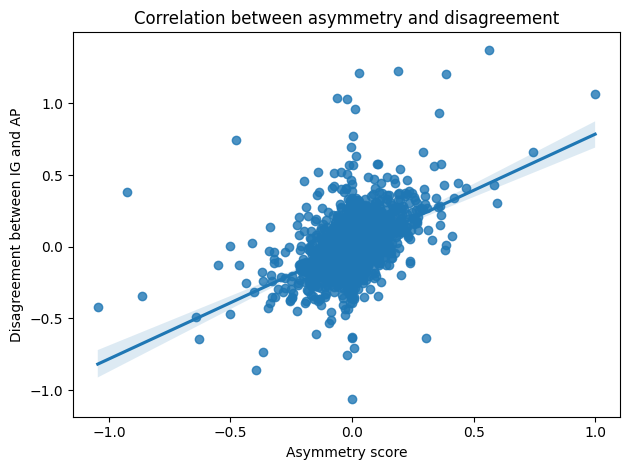

Correlation coefficient: 0.4537135586737552


In [71]:
plot_correlation(
    ap_mlp_asymmetry[:5],
    and_mlp[:5],
    x_label="Asymmetry score",
    y_label="Disagreement between IG and AP",
    title="Correlation between asymmetry and disagreement",
)

plot_correlation(
    ap_mlp_asymmetry[:5],
    or_mlp[:5],
    x_label="Asymmetry score",
    y_label="Disagreement between IG and AP",
    title="Correlation between asymmetry and disagreement",
)

In [65]:
score_threshold = 0.25
disagreement_threshold = 0.25

# IG > AP
# filtered_and_mlp = torch.where((ap_corrupt_clean_mlp.abs() > threshold), and_mlp, float('nan'))
# filtered_and_attn = torch.where((ap_corrupt_clean_attn.abs() > threshold), and_attn, float('nan'))
filtered_and_mlp = torch.where((ap_mlp_asymmetry.abs() > disagreement_threshold), and_mlp, float('nan'))
filtered_and_attn = torch.where((ap_attn_asymmetry.abs() > disagreement_threshold), and_attn, float('nan'))
# filtered_and_mlp = torch.where(and_mlp > 0, and_mlp, float('nan'))
# filtered_and_attn = torch.where((and_attn > 0), and_attn, float('nan'))
# filtered_and_mlp = torch.where((ap_corrupt_clean_mlp.abs() > score_threshold) & (and_mlp.abs() > disagreement_threshold), and_mlp, float('nan'))
# filtered_and_attn = torch.where((ap_corrupt_clean_attn.abs() > score_threshold) & (and_attn.abs() > disagreement_threshold), and_attn, float('nan'))
# filtered_and_mlp = torch.where((ap_mlp_asymmetry.abs() > score_threshold) & (and_mlp.abs() > disagreement_threshold), and_mlp, float('nan'))
# filtered_and_attn = torch.where((ap_attn_asymmetry.abs() > score_threshold) & (and_attn.abs() > disagreement_threshold), and_attn, float('nan'))


# AP > IG
# filtered_or_mlp = torch.where((ap_clean_corrupt_mlp.abs() > threshold), or_mlp, float('nan'))
# filtered_or_attn = torch.where((ap_clean_corrupt_attn.abs() > threshold), or_attn, float('nan'))
filtered_or_mlp = torch.where((ap_mlp_asymmetry.abs() > disagreement_threshold), or_mlp, float('nan'))
filtered_or_attn = torch.where((ap_attn_asymmetry.abs() > disagreement_threshold), or_attn, float('nan'))
# filtered_or_mlp = torch.where((or_mlp > 0), or_mlp, float('nan'))
# filtered_or_attn = torch.where((or_attn > 0), or_attn, float('nan'))
# filtered_or_mlp = torch.where((ap_clean_corrupt_mlp.abs() > score_threshold) & (or_mlp.abs() > disagreement_threshold), or_mlp, float('nan'))
# filtered_or_attn = torch.where((ap_clean_corrupt_attn.abs() > score_threshold) & (or_attn.abs() > disagreement_threshold), or_attn, float('nan'))
# filtered_or_mlp = torch.where((ap_mlp_asymmetry.abs() > score_threshold) & (or_mlp.abs() > disagreement_threshold), or_mlp, float('nan'))
# filtered_or_attn = torch.where((ap_attn_asymmetry.abs() > score_threshold) & (or_attn.abs() > disagreement_threshold), or_attn, float('nan'))

In [66]:
# Correlation between asymmetry (latents) and disagreements (IG > AP) for filtered data
from testing import average_correlation

filtered_mlp_and_corr, filtered_mlp_and_corr_std = average_correlation(ap_mlp_asymmetry, filtered_and_mlp)
print(f"Filtered MLP AND correlation: {filtered_mlp_and_corr:.4f} ± {filtered_mlp_and_corr_std:.4f}")

filtered_attn_and_corr, filtered_attn_and_corr_std = average_correlation(ap_attn_asymmetry, filtered_and_attn)
print(f"Filtered Attention AND correlation: {filtered_attn_and_corr:.4f} ± {filtered_attn_and_corr_std:.4f}")

filtered_mlp_or_corr, filtered_mlp_or_corr_std = average_correlation(ap_mlp_asymmetry, filtered_or_mlp)
print(f"Filtered MLP OR correlation: {filtered_mlp_or_corr:.4f} ± {filtered_mlp_or_corr_std:.4f}")

filtered_attn_or_corr, filtered_attn_or_corr_std = average_correlation(ap_attn_asymmetry, filtered_or_attn)
print(f"Filtered Attention OR correlation: {filtered_attn_or_corr:.4f} ± {filtered_attn_or_corr_std:.4f}")

Filtered MLP AND correlation: -0.5138 ± 0.4112
Filtered Attention AND correlation: -0.2252 ± 0.3914
Filtered MLP OR correlation: 0.4309 ± 0.4818
Filtered Attention OR correlation: -0.2896 ± 0.4082


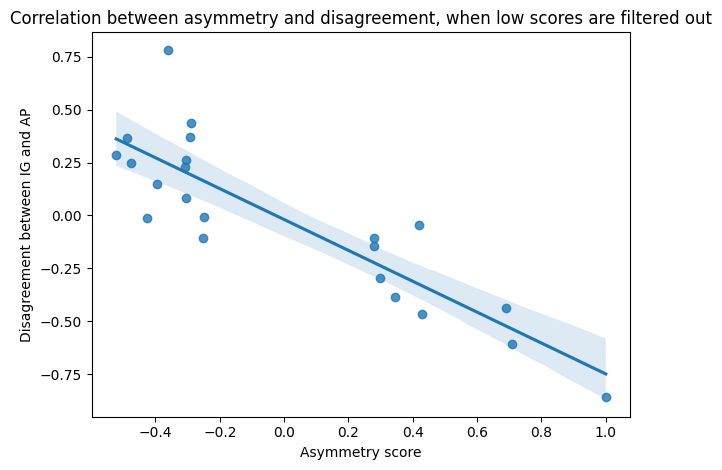

Correlation coefficient: -0.8683871027293973


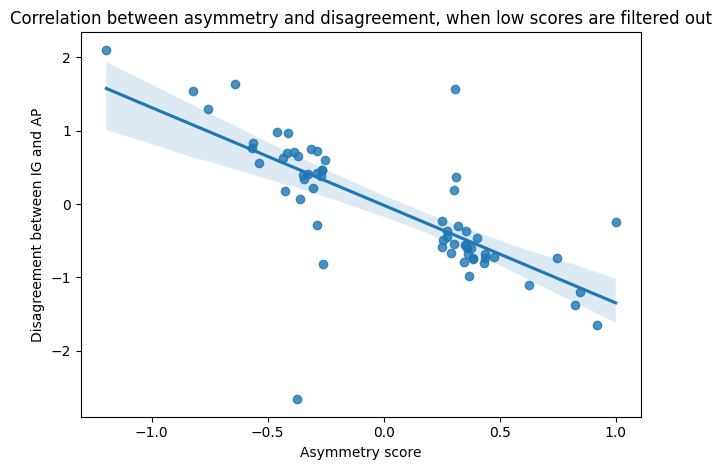

Correlation coefficient: -0.7330043997471056


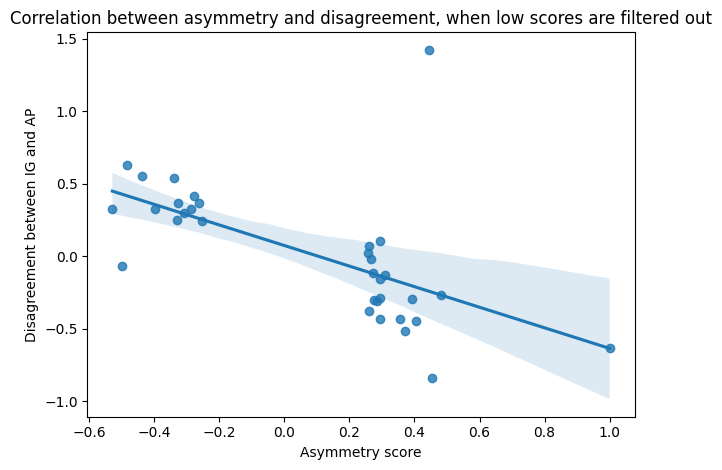

Correlation coefficient: -0.6067616244983293


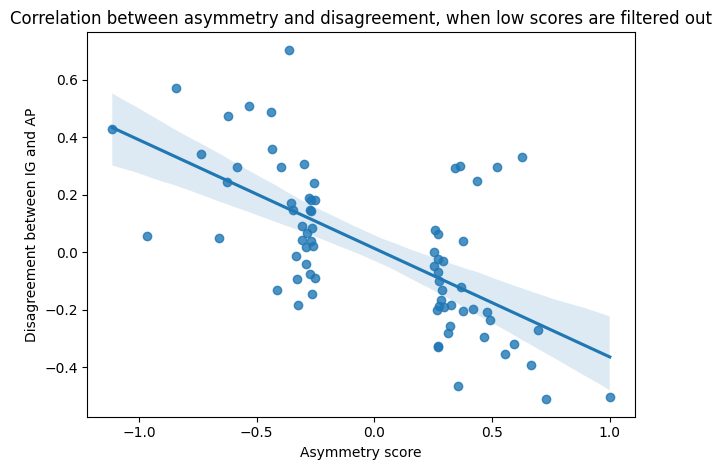

Correlation coefficient: -0.6468187017545125


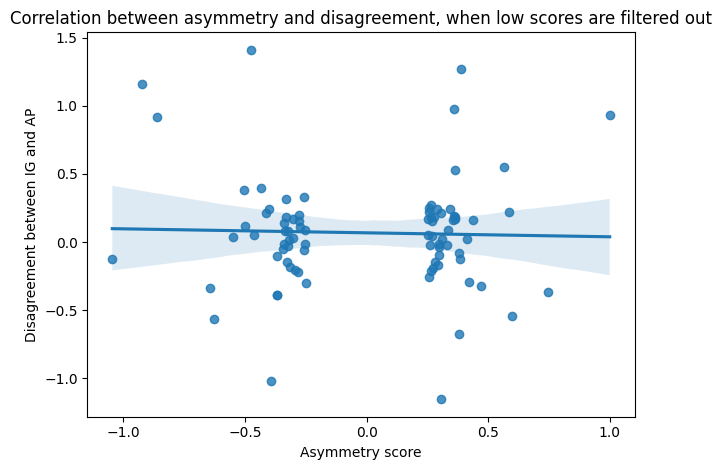

Correlation coefficient: -0.029886126741584036


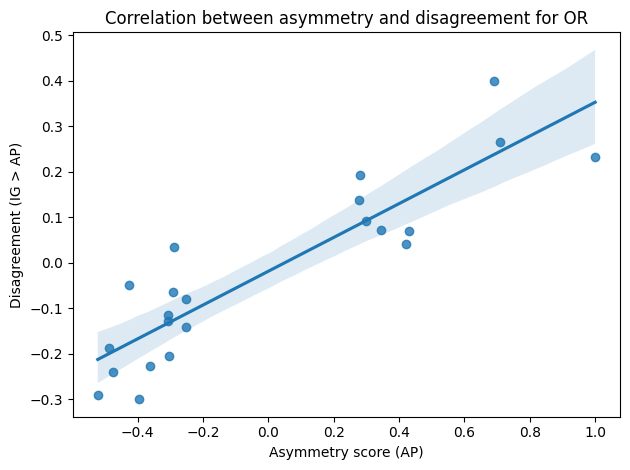

Correlation coefficient: 0.8929914113427859


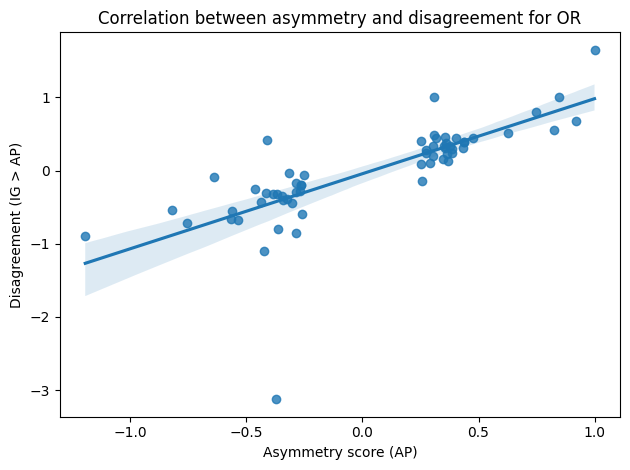

Correlation coefficient: 0.7487974495857614


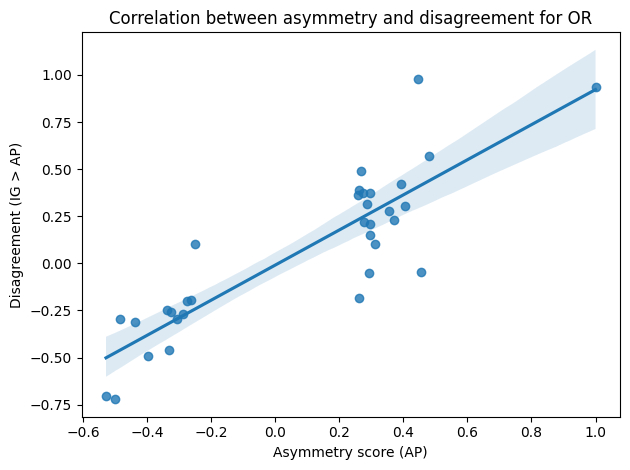

Correlation coefficient: 0.869589952521316


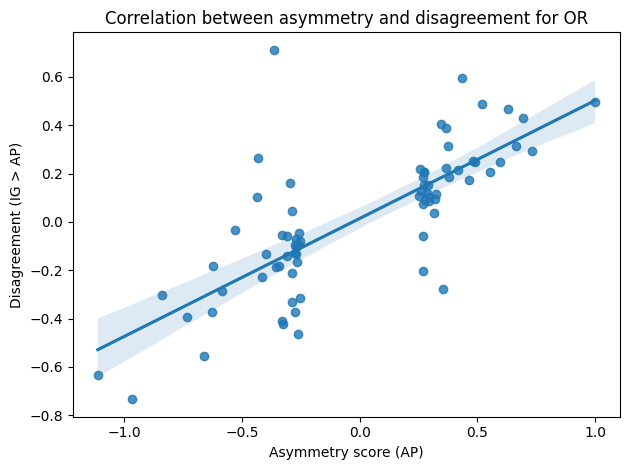

Correlation coefficient: 0.7593957714371748


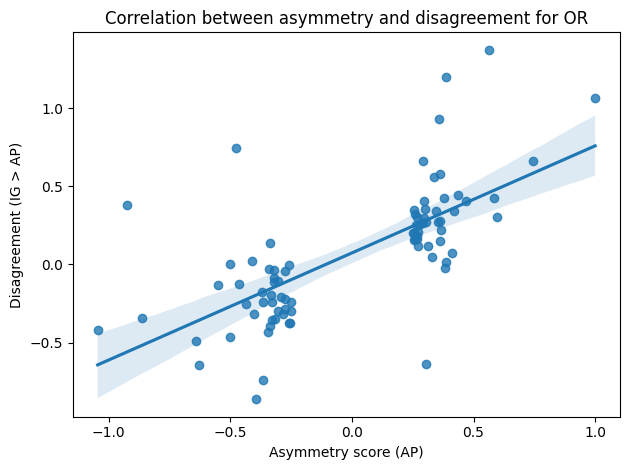

Correlation coefficient: 0.6921929049065657


In [72]:
plot_correlation(
    ap_mlp_asymmetry[:5],
    filtered_and_mlp[:5],
    x_label="Asymmetry score",
    y_label="Disagreement between IG and AP",
    title="Correlation between asymmetry and disagreement, when low scores are filtered out",
)

plot_correlation(
    ap_mlp_asymmetry[:5],
    filtered_or_mlp[:5],
    x_label="Asymmetry score (AP)",
    y_label="Disagreement (IG > AP)",
    title="Correlation between asymmetry and disagreement for OR",
)

In [67]:
from matplotlib.colors import TwoSlopeNorm
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable

# Plot clean-corrupt vs corrupt-clean for MLP (asymmetry)
# Categorise by disagreement between IG and AP
plt.figure(figsize=(8, 8))

norm = TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)
cmap = plt.cm.coolwarm

xs = ap_corrupt_clean_mlp.flatten().cpu().numpy()
ys = ap_clean_corrupt_mlp.flatten().cpu().numpy()
hue = and_mlp.flatten().cpu().numpy()

# sns.regplot(x=xs, y=ys, scatter=False, ci=None, color='gray', line_kws={'linestyle': '--'})
scatter = sns.scatterplot(x=xs, y=ys, hue=hue, palette=cmap, hue_norm=norm, edgecolor=None, alpha=0.8)

plt.title("Clean->Corrupt vs. Corrupt->Clean scores for Exclusive Neurons")
plt.xlabel("Corrupt->Clean Attribution Score")
plt.ylabel("Clean->Corrupt Attribution Score")
plt.grid(True)

# Create colorbar instead of legend
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=scatter, pad=0.02)
cbar.set_label("Disagreement (corrupt-clean)")

plt.show()

KeyboardInterrupt: 

/vol/bitbucket/mwl21/fypvenv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


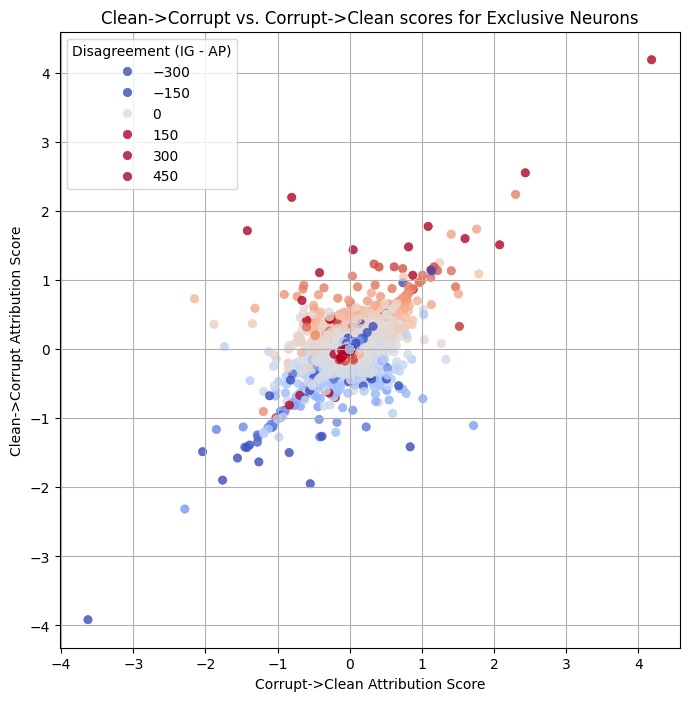

In [130]:
from matplotlib.colors import TwoSlopeNorm
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable


# Plot clean-corrupt vs corrupt-clean for MLP (asymmetry)
# Categorise by disagreement between IG and AP
plt.figure(figsize=(8, 8))

norm = TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)

xs = ap_corrupt_clean_mlp.flatten().cpu().numpy()
ys = ap_clean_corrupt_mlp.flatten().cpu().numpy()
hue = or_mlp.flatten().cpu().numpy()

# sns.regplot(x=xs, y=ys, scatter=False, ci=None, color='gray', line_kws={'linestyle': '--'})
sns.scatterplot(x=xs, y=ys, hue=hue, palette="coolwarm", hue_norm=norm, edgecolor=None, alpha=0.8)

plt.title("Clean->Corrupt vs. Corrupt->Clean scores for Exclusive Neurons")
plt.xlabel("Corrupt->Clean Attribution Score")
plt.ylabel("Clean->Corrupt Attribution Score")
plt.grid(True)

# Create colorbar instead of legend
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([-3, -2, -1, 0, 1, 2, 3])
cbar = plt.colorbar(sm, ax=scatter, pad=0.02)
cbar.set_label("Disagreement (clean-corrupt)")

plt.show()

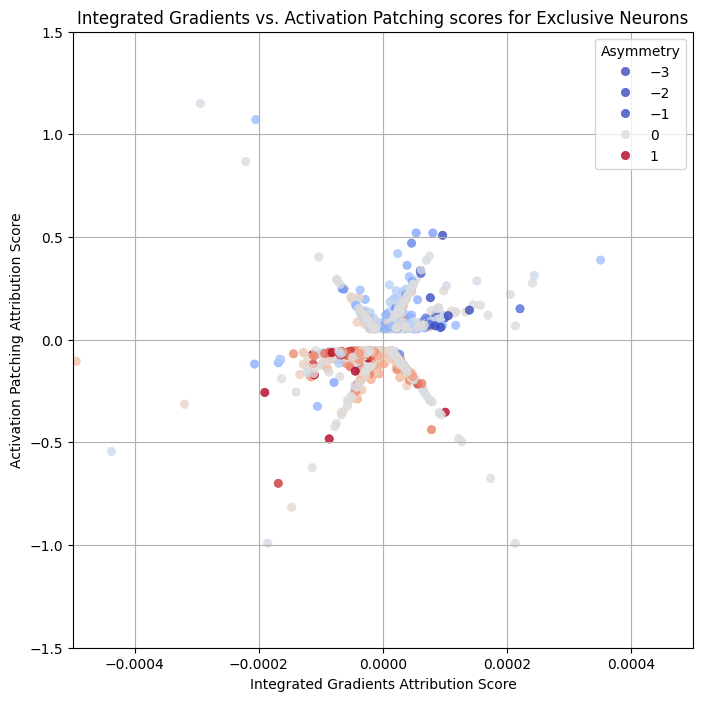

In [127]:
from matplotlib.colors import TwoSlopeNorm
import seaborn as sns
import matplotlib.pyplot as plt

# Plot IG vs AP score for neuron outliers
xs = []
ys = []
hue = []

for s, sample_mlp_outlier_iso in enumerate(mlp_outlier_iso):
    for layer, idx in sample_mlp_outlier_iso.keys():
        ig_score = ig_mlp[s, layer, idx]
        ap_score = ap_mlp[s, layer, idx]
        xs.append(ig_score.item())
        ys.append(ap_score.item())
        hue.append(ap_mlp_asymmetry[s, layer, idx].item())

plt.figure(figsize=(8, 8))

norm = TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)

# sns.regplot(x=xs, y=ys, scatter=False, ci=None, color='gray', line_kws={'linestyle': '--'})
sns.scatterplot(x=xs, y=ys, hue=hue, palette="coolwarm", hue_norm=norm, edgecolor=None, alpha=0.5)

plt.title("Integrated Gradients vs. Activation Patching scores for Exclusive Neurons")
plt.xlabel("Integrated Gradients Attribution Score")
plt.ylabel("Activation Patching Attribution Score")
plt.grid(True)
plt.legend(title="Asymmetry")
plt.ylim(-1.5, 1.5)
plt.xlim(-5e-4, 5e-4)
plt.show()

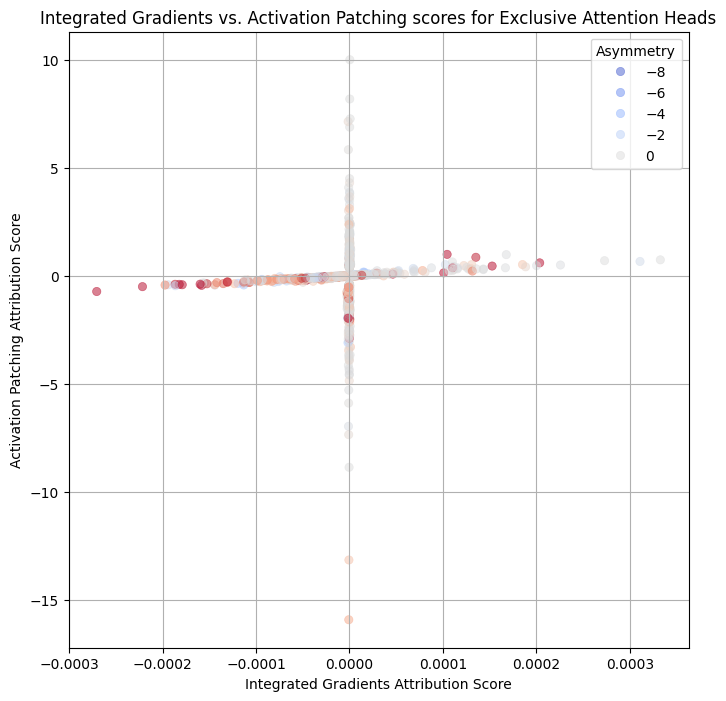

In [43]:
from matplotlib.colors import TwoSlopeNorm
import seaborn as sns
import matplotlib.pyplot as plt

# Plot IG vs AP score for neuron outliers
xs = []
ys = []
hue = []

for s, sample_attn_outlier_iso in enumerate(attn_outlier_iso):
    for layer, idx in sample_attn_outlier_iso.keys():
        ig_score = ig_attn[s, layer, idx]
        ap_score = ap_attn[s, layer, idx]
        xs.append(ig_score.item())
        ys.append(ap_score.item())
        hue.append(ap_attn_asymmetry[s, layer, idx].item())

plt.figure(figsize=(8, 8))

norm = TwoSlopeNorm(vcenter=0)

# sns.regplot(x=xs, y=ys, scatter=False, ci=None, color='gray', line_kws={'linestyle': '--'})
sns.scatterplot(x=xs, y=ys, hue=hue, palette="coolwarm", hue_norm=norm, edgecolor=None, alpha=0.5)

plt.title("Integrated Gradients vs. Activation Patching scores for Exclusive Attention Heads")
plt.xlabel("Integrated Gradients Attribution Score")
plt.ylabel("Activation Patching Attribution Score")
plt.grid(True)
plt.legend(title="Asymmetry")

plt.show()

## XXX

When corrupt-clean and clean-corrupt scores disagree (asymmetry), IG should be moderate.

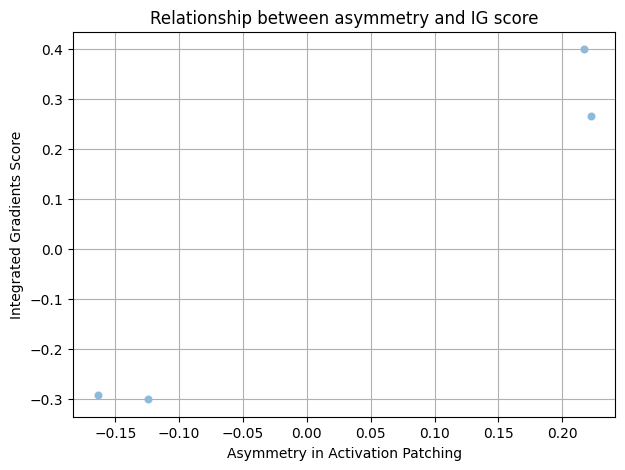

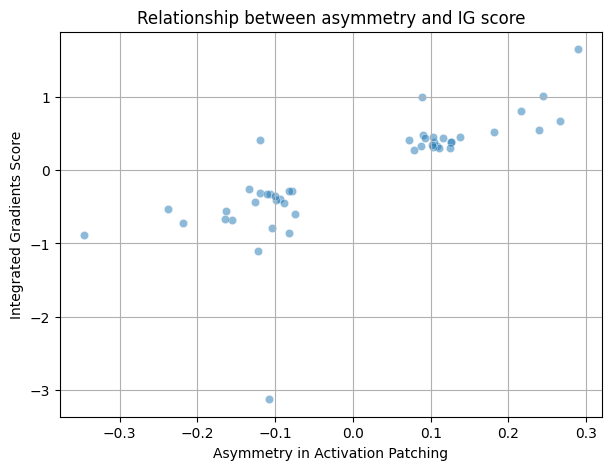

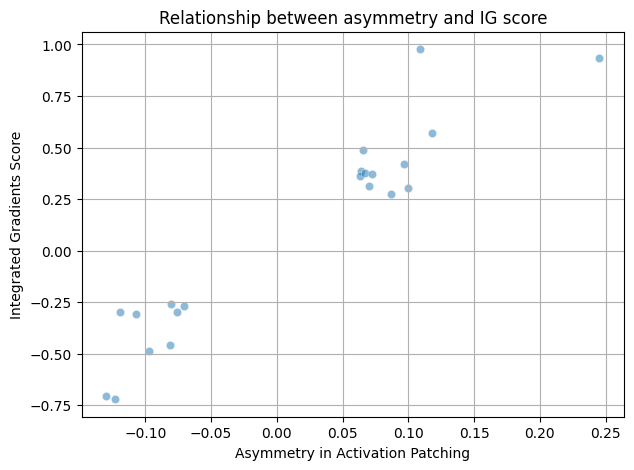

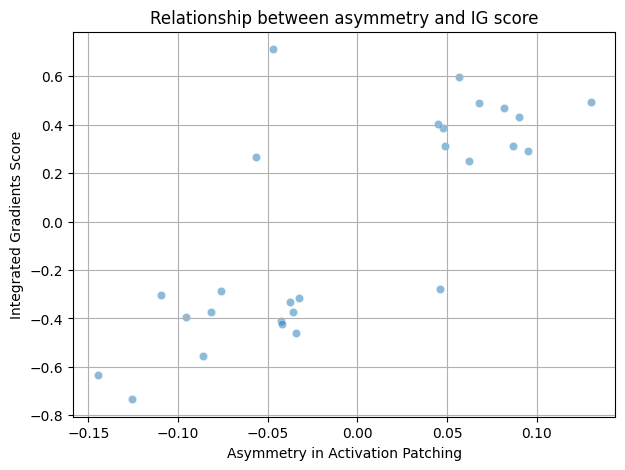

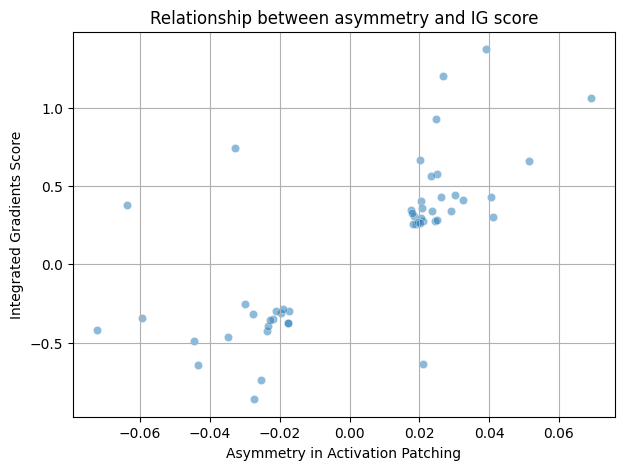

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

for i in range(5):
    asymmetry = (ap_corrupt_clean_mlp - ap_clean_corrupt_mlp)[i].flatten().cpu().numpy()
    disagreement = filtered_or_mlp[i].flatten().cpu().numpy()

    plt.figure(figsize=(7, 5))
    sns.scatterplot(x=asymmetry, y=disagreement, alpha=0.5)
    # sns.regplot(x=asymmetry, y=ig_score, order=2, scatter=False, color='black', label='Quadratic fit')
    plt.xlabel("Asymmetry in Activation Patching")
    plt.ylabel("Integrated Gradients Score")
    plt.title("Relationship between asymmetry and IG score")
    plt.grid(True)
    plt.show()


/tmp/ipykernel_33638/3591448804.py:11: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1839.)
  bin_stds = [ig_corrupt_clean_mlp[digitized == i].std() for i in range(1, len(bins))]


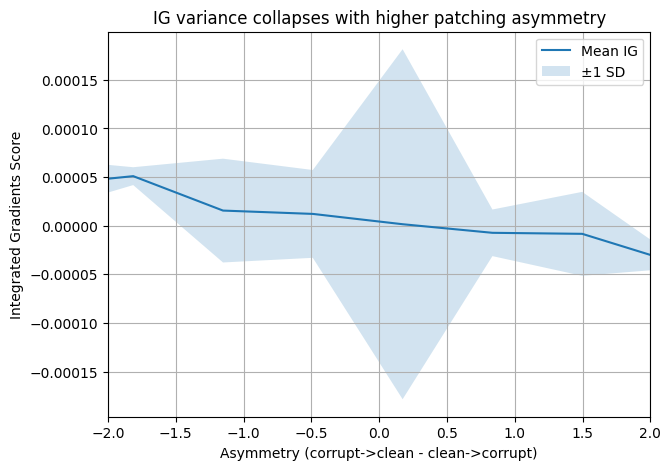

In [58]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

asymmetry = ap_corrupt_clean_mlp - ap_clean_corrupt_mlp

# Bin asymmetry values
bins = np.linspace(asymmetry.min(), asymmetry.max(), 10)
digitized = np.digitize(asymmetry, bins)
bin_means = [ig_corrupt_clean_mlp[digitized == i].mean() for i in range(1, len(bins))]
bin_stds = [ig_corrupt_clean_mlp[digitized == i].std() for i in range(1, len(bins))]

plt.figure(figsize=(7, 5))
plt.plot(bins[1:], bin_means, label="Mean IG")
plt.fill_between(bins[1:], np.array(bin_means)-np.array(bin_stds), np.array(bin_means)+np.array(bin_stds), alpha=0.2, label="±1 SD")
plt.xlabel("Asymmetry (corrupt->clean - clean->corrupt)")
plt.ylabel("Integrated Gradients Score")
plt.title("Variance of IG with Asymmetry in neurons")
plt.grid(True)
plt.legend()
plt.xlim(-2, 2)
plt.show()
